# Lempel-Ziv complexity for the Simons game

### **Author:** Quilee Simeon (qsimeon@mit.edu)

The Lempel–Ziv complexity is the number of **different sub-strings (or sub-words) encountered as the binary sequence is viewed as a stream (from left to right)**.

Could **this** be a definition of what a *chunk* is?

The core algorithm, which involves searching for unique substrings and updating indices accordingly, remains the same regardless of the alphabet size of the sequence.

For sequences derived from an alphabet larger than binary, you simply ensure that the sequence you input into the function is in a form where each symbol is distinct and treated as such by the algorithm. No conversion to a binary format is necessary, as the algorithm does not rely on the nature of the symbols but rather on the structure and repetition of patterns.

In [24]:
def lempel_ziv_complexity(sequence):
    i, l = 0, 1
    s = 0  # complexity
    sub_strings = set()

    while i + l <= len(sequence):
        w = sequence[i : i + l]
        if w not in sub_strings:
            sub_strings.add(w)
            i = i + l
            l = 1
            s += 1
        else:
            l += 1

    return s


# Example usage:
sequence = "BRRBRBRBB"  # binary
lz_complexity = lempel_ziv_complexity(sequence)
print(f"The Lempel-Ziv complexity of the sequence {sequence} is: {lz_complexity}")

# Example usage:
sequence = "YBGGRRGBBYY"  # quarternary
lz_complexity = lempel_ziv_complexity(sequence)
print(f"The Lempel-Ziv complexity of the sequence {sequence} is: {lz_complexity}")

The Lempel-Ziv complexity of the sequence BRRBRBRBB is: 5
The Lempel-Ziv complexity of the sequence YBGGRRGBBYY is: 7


### Define a **chunk**
Given a sequence of characters, a _chunk_ is a subword/substring that allows that sequence to be encoded in a more compressed way than if every character was encoded distinctly.

### How to measure chunkablity
chunkability $\propto$ (LZ complexity)${}^{-1}$, LZ =  Lempel-Ziv.

In [25]:
import os
import pandas as pd


def parse_simon_game_csv(filepath):
    # Parse the CSV file and convert the color names to single characters
    dataframe = pd.read_csv(filepath)
    dataframe["Event"] = dataframe["Event"].map(
        {"red": "R", "blue": "B", "green": "G", "yellow": "Y"}
    )
    # Because there may be multiple gameplays in a single file,
    # we need to split the data frame whenever Score reset to 0.
    # Create a group id that increments each time Score is 0
    dataframe["group_id"] = (dataframe["Score"] == 0).cumsum()
    # Split the data into subdataframes based on group_id
    subdataframes = [group for _, group in dataframe.groupby("group_id")]
    game_results = dict((i + 1, None) for i in range(len(subdataframes)))
    for data in subdataframes:
        # Get the longest chain the player was able to reproduce
        # and the chain they made when the made a mistake.
        best_and_last = data[data.Score >= max(data.Score) - 1]
        # print(best_and_last)
        longest_sequence = "".join(
            best_and_last[
                best_and_last.Score == best_and_last.iloc[0].Score
            ].Event.to_list()
        )
        mistake_sequence = "".join(
            best_and_last[
                best_and_last.Score == best_and_last.iloc[-1].Score
            ].Event.to_list()
        )
        game_number = data.iloc[0].group_id
        # Dictionary containing the longest sequence and the mistake sequence
        game_sequences = {
            "longest_sequence": longest_sequence,
            "mistake_sequence": mistake_sequence,
        }
        game_results[game_number] = game_sequences
    return game_results


# def parse_simons_game_logs(directory):
#     session_data = {}
#     # List all CSV files in the specified directory
#     csv_files = [f for f in os.listdir(directory) if f.endswith(".csv")]
#     for file in csv_files:
#         filepath = os.path.join(directory, file)
#         game_sequences = parse_simon_game_csv(filepath)
#         session_data[file] = game_sequences
#     return session_data


def parse_simons_game_logs(directory):
    session_data = {}
    # Traverse the directory tree
    for root, dirs, files in os.walk(directory):
        # Get all CSV files in the specified directory
        for file in files:
            if file.endswith(".csv"):
                filepath = os.path.join(root, file)
                game_sequences = parse_simon_game_csv(filepath)
                session_data[filepath] = (
                    game_sequences  # Storing with filepath as key to prevent overwriting
                )
    return session_data


# Example usage
directory_path = "./Hokyung_logs"  # Update this path accordingly
print(f"Simon's game logs session: {directory_path}\n")

session_data = parse_simons_game_logs(directory_path)
print(f"Game files from this session: {list(session_data.keys())}\n")

game_file = list(session_data.keys())[-1]
print(f"Analyzing the game: {game_file}\n")

game_sequences = session_data[game_file]
print(f"List of games in this file: {list(game_sequences.keys())}\n")

for game_number in game_sequences.keys():
    sequence = game_sequences[game_number]["longest_sequence"]
    print(f"\tLongest sequence for game {game_number}: {sequence}\n")
    lz_score = round(lempel_ziv_complexity(sequence) / len(sequence), 3)
    print(f"\tLempel-Ziv complexity normalized by sequence length: {lz_score}\n")

Simon's game logs session: ./Hokyung_logs

Game files from this session: ['./Hokyung_logs/simon_log_hokyung_20_00_27.csv']

Analyzing the game: ./Hokyung_logs/simon_log_hokyung_20_00_27.csv

List of games in this file: [1, 2, 3]

	Longest sequence for game 1: GRRBBYYBBYBY

	Lempel-Ziv complexity normalized by sequence length: 0.583

	Longest sequence for game 2: YGGYGGGGYRRGBRBYBBRBG

	Lempel-Ziv complexity normalized by sequence length: 0.571

	Longest sequence for game 3: BGGBGGGBYYBGYBBBBBGGYBBYB

	Lempel-Ziv complexity normalized by sequence length: 0.48



### Collect data from all logs and make a plot of LZ-complexity versus sequence length.

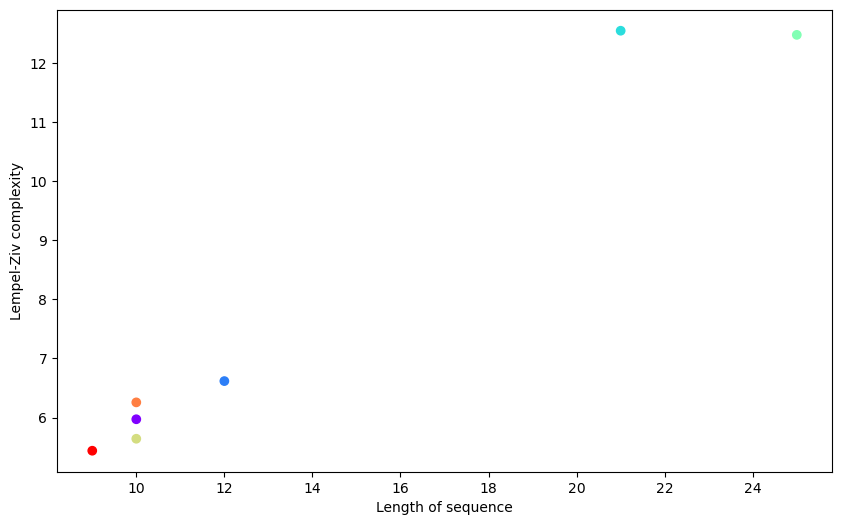

In [27]:
import numpy as np
import matplotlib.pyplot as plt

root_path = "."  # all the games are within subdirectories
all_sessions_data = parse_simons_game_logs(root_path)

sequences, scores = [], []
for session in all_sessions_data:
    session_data = all_sessions_data[session]
    for game in session_data:
        sequence = session_data[game]["longest_sequence"]
        sequences.append(sequence)
        score = round(lempel_ziv_complexity(sequence), 3)
        scores.append(score)
lengths = np.array([len(seq) for seq in sequences])
colors = plt.cm.rainbow(np.linspace(0, 1, len(lengths)))
jitters = np.random.randn(len(lengths)) * 0.5

plt.figure(figsize=(10, 6))
plt.scatter(lengths, scores + jitters, color=colors)
plt.xlabel("Length of sequence")
plt.ylabel("Lempel-Ziv complexity")
plt.show()

#### Jack's hypothesis 
Chunking or repeat substrings is implemented neurally as a population of cells that modulates firing rate as a function of repeats.

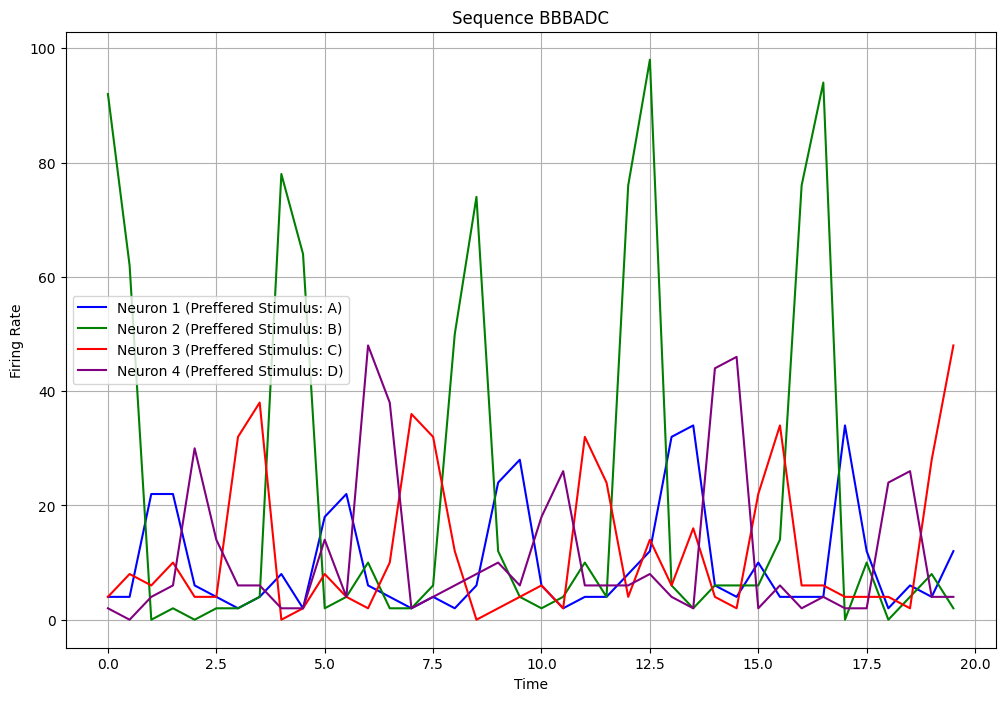
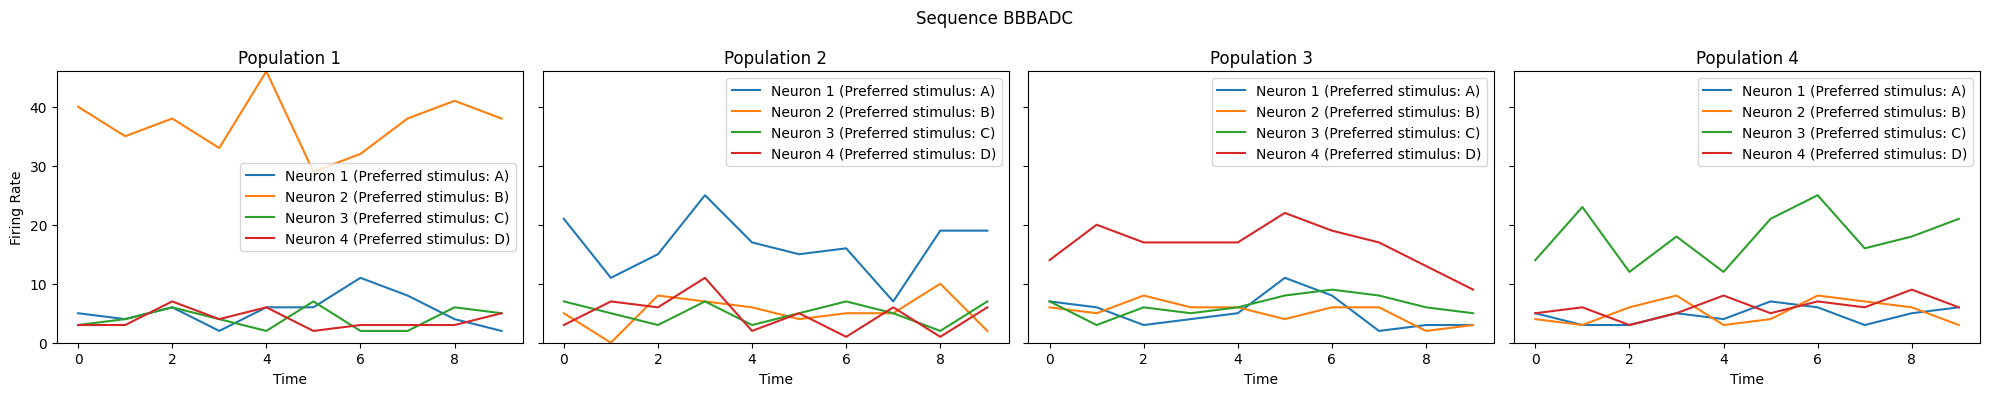